# GEOG5995M Final Assignment

Student ID number: 201793746 

In [312]:
# import required packages
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import geoplot.crs as gcrs

# hide formatting warning for .catplot
import warnings
warnings.filterwarnings('ignore')

## Hypothesis 1: 
Bradford students who are eligible for free school means (FSM) will have higher rates of 'overall absence', 'unauthorised absence', 'persistent absence' (10 sessions or more) and 'severe absence' (50 sessions or more) during the 2021/22 academic year, than students who are not eligible for FSM.

In [313]:
# read in dataframe containing data on Bradford school absense rates by characteristic and academic year
attendance = pd.read_csv("Attendance Academic Years 1718  2122.csv")

# check dataframe
attendance.head()

,Location,Year,Characteristic,School Type,Enrolments,Total Attendance Sessions,Total Sessions - Absence,Authorised Absence Sessions,Unauthorised Absence Sessions,Overall Absence Rate (%),Authorised Absence Rate (%),Unauthorised Absence Rate (%),Enrolments - Persistent Absence (10 or more sessions),Persistent Absence Rate (%),Enrolments - Severe Absence (50 or more sessions),Severe Absence Rate
0,Bradford,201718,Ethnicity Major Any Other Ethnic Group,State-funded secondary,409,138998,7152,3369,3783,5.14540,2.42378,2.72162,49,11.98044,4,0.977995
1,Bradford,201718,Ethnicity Major Any Other Ethnic Group,Special,8,2835,332,292,40,11.71076,10.29982,1.41093,2,25.00000,0,0.000000
2,Bradford,201718,Ethnicity Major Any Other Ethnic Group,State-funded primary,755,255080,10015,5767,4248,3.92622,2.26086,1.66536,75,9.93377,2,0.264901
3,Bradford,201718,Ethnicity Major Any Other Ethnic Group,Total,1172,396913,17499,9428,8071,4.40877,2.37533,2.03344,126,10.75085,6,0.511945
4,Bradford,201819,Ethnicity Major Any Other Ethnic Group,Special,10,2868,389,372,17,13.56346,12.97071,0.59275,5,50.00000,1,10.000000


In [314]:
# check data types to inform dataframe filtering criteria
attendance.dtypes

Location                                                  object
Year                                                       int64
Characteristic                                            object
School Type                                               object
Enrolments                                                 int64
Total Attendance Sessions                                  int64
Total Sessions - Absence                                   int64
Authorised Absence Sessions                                int64
Unauthorised Absence Sessions                              int64
Overall Absence Rate (%)                                 float64
Authorised Absence Rate (%)                              float64
Unauthorised Absence Rate (%)                            float64
Enrolments - Persistent Absence (10 or more sessions)      int64
Persistent Absence Rate (%)                              float64
Enrolments - Severe Absence (50 or more sessions)          int64
Severe Absence Rate      

In [315]:
# create a list of the FSM characteristics that I am interested in
characteristics = ['FSM eligible', 'FSM Not eligible']

# filter dataframe to show data for the latest year, total school type and according to FSM eligibility
attendance_2122 = attendance.loc[(attendance['Year'] == 202122) & (attendance['School Type'] == 'Total') & 
                                 (attendance['Characteristic'].isin(characteristics))]

# check filtering has worked as expected
attendance_2122

,Location,Year,Characteristic,School Type,Enrolments,Total Attendance Sessions,Total Sessions - Absence,Authorised Absence Sessions,Unauthorised Absence Sessions,Overall Absence Rate (%),Authorised Absence Rate (%),Unauthorised Absence Rate (%),Enrolments - Persistent Absence (10 or more sessions),Persistent Absence Rate (%),Enrolments - Severe Absence (50 or more sessions),Severe Absence Rate
854,Bradford,202122,FSM eligible,Total,25055,8668948,1075307,557709,517598,12.40412,6.43341,5.97071,10407,41.53662,1164,4.645779
1058,Bradford,202122,FSM Not eligible,Total,60518,21398795,1637021,1053505,583516,7.65006,4.92320,2.72686,13847,22.88080,926,1.530123


In [316]:
# remove data columns that aren't needed ahead of 'melting' the dataframe
absence = attendance_2122.drop(columns = ['Location', 'Year', 'School Type', 'Enrolments', 
                                          'Total Attendance Sessions', 'Total Sessions - Absence', 
                                          'Authorised Absence Sessions', 'Unauthorised Absence Sessions', 
                                          'Authorised Absence Rate (%)', 'Enrolments - Persistent Absence (10 or more sessions)',
                                          'Enrolments - Severe Absence (50 or more sessions)'])
absence

,Characteristic,Overall Absence Rate (%),Unauthorised Absence Rate (%),Persistent Absence Rate (%),Severe Absence Rate
854,FSM eligible,12.40412,5.97071,41.53662,4.645779
1058,FSM Not eligible,7.65006,2.72686,22.88080,1.530123


In [317]:
# use dictionary to rename columns to be more consisent and succinct
absence.rename(columns={'Overall Absence Rate (%)': 'Overall', 'Unauthorised Absence Rate (%)': 'Unauthorised', 
                        'Persistent Absence Rate (%)': 'Persistent', 'Severe Absence Rate': 'Severe'}, 
               inplace=True)

absence

,Characteristic,Overall,Unauthorised,Persistent,Severe
854,FSM eligible,12.40412,5.97071,41.53662,4.645779
1058,FSM Not eligible,7.65006,2.72686,22.88080,1.530123


The structure of this dataframe makes it difficult to present in a visualisation in the way that I would like. The 'melt' function can be used to split 'type of absence' and 'absence rate' into seperate variables, so that I can present the data as a clustered bar chart.

In [318]:
# melt dataframe to make it easier to explore through a visualisation
absence_melt = absence.melt(id_vars=['Characteristic'], var_name='Type of Absence', value_name='Absence Rate')
absence_melt

,Characteristic,Type of Absence,Absence Rate
0,FSM eligible,Overall,12.404120
1,FSM Not eligible,Overall,7.650060
2,FSM eligible,Unauthorised,5.970710
3,FSM Not eligible,Unauthorised,2.726860
4,FSM eligible,Persistent,41.536620
5,FSM Not eligible,Persistent,22.880800
6,FSM eligible,Severe,4.645779
7,FSM Not eligible,Severe,1.530123


It is clear from the table above that each type of absence rate cannot be referring to the same baseline, for example, the persistent absence rates are higher than the overall absence rates. 

'Overall absence rate' represents the number of sessions missed out of the total number of school sessions in the year, and 'unauthorised absence rate' represents how many of these missed sessions were unauthorised. 

However, the persistent and severe absence rates represent the number of students, out of the total number enrolled, who missed a high enough number of sessions each that they met the threshold for persistent or severe absence (10 or 50 respectively). 

If I were to present all of this data in a single bar chart below it would be misleading. For example, the audience may incorrectly infer that persistent absence is more prevalent in schools than unauthorised absence.

Therefore, I need to create an additional colomn idicating whether each item represents the rate of sessions or the rate of students. 

In [319]:
sessions_students = ['Sessions', 'Sessions', 'Sessions', 'Sessions', 'Students', 'Students', 'Students', 'Students']

absence_melt['Sessions or Students'] = sessions_students

absence_melt

,Characteristic,Type of Absence,Absence Rate,Sessions or Students
0,FSM eligible,Overall,12.404120,Sessions
1,FSM Not eligible,Overall,7.650060,Sessions
2,FSM eligible,Unauthorised,5.970710,Sessions
3,FSM Not eligible,Unauthorised,2.726860,Sessions
4,FSM eligible,Persistent,41.536620,Students
5,FSM Not eligible,Persistent,22.880800,Students
6,FSM eligible,Severe,4.645779,Students
7,FSM Not eligible,Severe,1.530123,Students


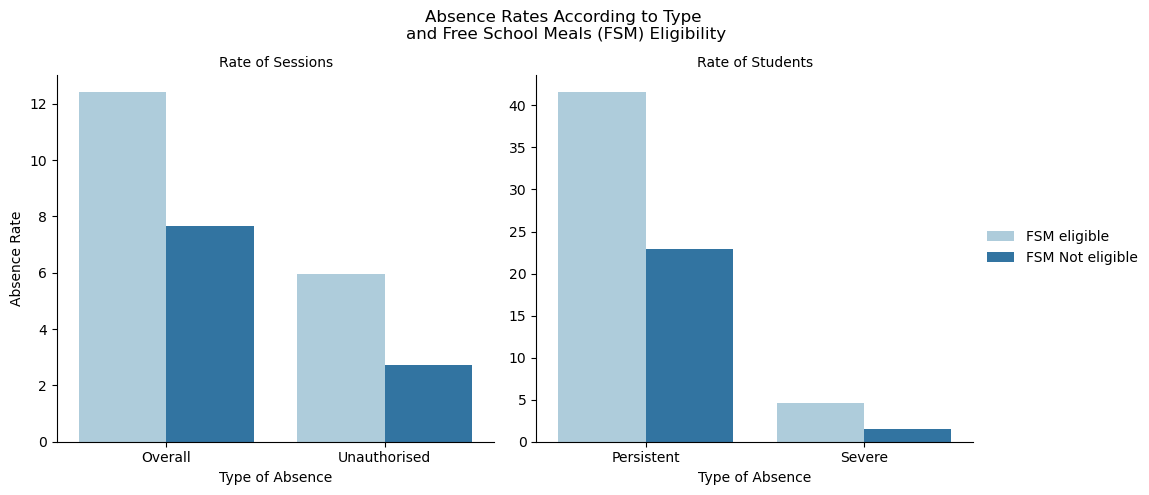

In [320]:
# plot categorical data
g = sns.catplot(data=absence_melt, x='Type of Absence', y='Absence Rate', hue='Characteristic', 
                col='Sessions or Students', palette='Paired', dodge=True, kind='bar', sharex=False, sharey=False);


# set titles
g.fig.subplots_adjust(top=0.85) #adjust top margin so that main title and subplot titles dont overlap
g.fig.suptitle('Absence Rates According to Type \nand Free School Meals (FSM) Eligibility')
g.set_titles(col_template='Rate of {col_name}')

# remove legend title
g._legend.set_title(None)

## Visualisation 1

Visualisation 1 has been created with Bradford City Council in mind, to help them to get a better understanding of how the issue of high rates of absence is affecting these two cohorts of children to different extents. 

A bar chart is appropriate for visualising the relationship between a numberical variable and different levels of a categorical variable. 

It is clear to see from this visualisation that children who are eligible for FSM have higher absence rates than those not eligible for FSM across all types of absence, and that the difference between the two groups is largest for 'Severe' absence.  

Within Bradford City Council, both the Education Service and Early Help Service would be able to use this information to justify focusing additional resources on investigating the underlying drivers for poor school attendance for children from lower socio-economic backgrounds. This is turn could inform more targeted interventions for this cohort. 

I have chosen the seaborn 'Paired' color scheme to reflect eligibility for FSM as a binary measure, and to avoid colours that imply any value judgement on either level of this variable. 

I have set a chart title that makes it clear at a glance what this visualisation is showing, including what the 'FSM' acronym represents. Earlier in my data preparation I relabelled all variables, so there was no need for further renaming of axis or tickmarks to make the visualisation more accessible. 

I used 'col=' to split the views between rates based on the total number of school sessions, and rates based on the total number of students, to reduce the risk of the audience drawing direct comparisons between these rates. 

I set 'sharex' to False so that empty values were not included on each x-axis. I also set 'sharey' to False because the rates of session absences are lower than the rates of student absences. This means that if they were to share a  y-axis range the contrast between the session absenses according to FSM eligibility would have been less clear as a result of being smaller. 


#### Next Steps
Next, I will consider absence rates at the school level, alongside Ofsted ratings as indicators of school performance. I will then explore the potential relationship between school performance and levels of deprivation in the local area using Indices of Multiple Deprivation (IMD) as a measure. 

## Hypothesis 2: 
Bradford schools with higher absence rates, and lower Ofsted ratings will be located in and around the most deprived (lower super output) areas of Bradford City.


#### Step 1:
Read in data on Bradford schools and prepare Ofsted rating data for analysis. 

In [371]:
# read in Bradford schools dataframe 
schools = pd.read_csv("Schools_LA.csv")

# check dataframe
schools

,URN,LA (code),EstablishmentNumber,EstablishmentName,TypeOfEstablishment (name),EstablishmentStatus (name),PhaseOfEducation (name),SchoolSponsors (name),OfstedLastInsp,Street,Town,Postcode,SchoolWebsite,TelephoneNum,HeadTitle (name),HeadFirstName,HeadLastName,ParliamentaryConstituency (name),OfstedRating (name)
0,107253,380,2111,Crossflatts Primary School,Community school,Open,Primary,NaN,16/10/2018,Morton Lane,Bingley,BD16 2EP,https://www.crossflatts.bradford.sch.uk/web,01274-782070,Mrs,Nicola,Bennett,Shipley,Good
1,107255,380,2113,Eldwick Primary School,Community school,Open,Primary,NaN,18/09/2018,Warren Lane,Bingley,BD16 3LE,www.eldwick.bradford.sch.uk,01274-568361,Mr,Daniel,Lomas,Shipley,Good
2,107437,380,5206,Myrtle Park Primary,Foundation school,Open,Primary,NaN,19/06/2019,Ash Terrace,Bingley,BD16 1HB,http://www.myrtleparkprimary.org,01274-564681,Mr,Kevin,Wheeler,Shipley,Good
3,107439,380,5400,Bingley Grammar School,Voluntary aided school,Open,Secondary,NaN,27/03/2018,Keighley Road,Bingley,BD16 2RS,http://www.bingleygrammar.org,01274-807700,Mr,Luke,Weston,Shipley,Good
4,139975,380,4064,Beckfoot School,Academy converter,Open,Secondary,Beckfoot Trust,05/06/2014,Wagon Lane,Bingley,BD16 1EE,www.beckfoot.org,01274-771444,Mr,Simon,Wade,Shipley,Outstanding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,146851,380,1104,Bradford Alternative Provision Academy,Academy alternative provision converter,Open,Not applicable,Exceed Academies Trust,NaN,Baker Street,Shipley,BD18 3JE,www.bradfordapacademy.co.uk,01274-585318,Mr,Richard,Bottomley,Shipley,NaN
211,147982,380,3373,"St Anthony's Catholic Primary School, A Volunt...",Academy converter,Open,Primary,Blessed Christopher Wharton Catholic Academy T...,NaN,High Busy Lane,Shipley,BD18 1HD,http://www.stanthonysshipley.org.uk,01274-592738,Mr,Ashley,Wilkinson,Shipley,NaN
212,149093,380,2069,Baildon Glen Primary School,Academy sponsor led,Open,Primary,Exceed Academies Trust,NaN,Thompson Lane,Shipley,BD17 7LY,https://www.glenaireprimary.co.uk/,01274-582514,Mrs,Kirsty,Hutchinson,Shipley,NaN
213,149161,380,3360,Baildon Church of England Primary School,Academy converter,Open,Primary,Bradford Diocesan Academies Trust,NaN,Coverdale Way,Shipley,BD17 6TE,www.baildonce.co.uk,01274-598540,Mrs,Katie,Savage,Shipley,NaN


In [372]:
# create a list of the education settings that I am interested in
settings = ['Primary', 'Secondary', 'All-through']

# filter dataframe to remove nursery, post-16 and NA settings
schools = schools.loc[(schools['PhaseOfEducation (name)'].isin(settings))]

# check filtering has worked as expected
schools

,URN,LA (code),EstablishmentNumber,EstablishmentName,TypeOfEstablishment (name),EstablishmentStatus (name),PhaseOfEducation (name),SchoolSponsors (name),OfstedLastInsp,Street,Town,Postcode,SchoolWebsite,TelephoneNum,HeadTitle (name),HeadFirstName,HeadLastName,ParliamentaryConstituency (name),OfstedRating (name)
0,107253,380,2111,Crossflatts Primary School,Community school,Open,Primary,NaN,16/10/2018,Morton Lane,Bingley,BD16 2EP,https://www.crossflatts.bradford.sch.uk/web,01274-782070,Mrs,Nicola,Bennett,Shipley,Good
1,107255,380,2113,Eldwick Primary School,Community school,Open,Primary,NaN,18/09/2018,Warren Lane,Bingley,BD16 3LE,www.eldwick.bradford.sch.uk,01274-568361,Mr,Daniel,Lomas,Shipley,Good
2,107437,380,5206,Myrtle Park Primary,Foundation school,Open,Primary,NaN,19/06/2019,Ash Terrace,Bingley,BD16 1HB,http://www.myrtleparkprimary.org,01274-564681,Mr,Kevin,Wheeler,Shipley,Good
3,107439,380,5400,Bingley Grammar School,Voluntary aided school,Open,Secondary,NaN,27/03/2018,Keighley Road,Bingley,BD16 2RS,http://www.bingleygrammar.org,01274-807700,Mr,Luke,Weston,Shipley,Good
4,139975,380,4064,Beckfoot School,Academy converter,Open,Secondary,Beckfoot Trust,05/06/2014,Wagon Lane,Bingley,BD16 1EE,www.beckfoot.org,01274-771444,Mr,Simon,Wade,Shipley,Outstanding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,146512,380,2050,Wycliffe CofE Primary School,Academy sponsor led,Open,Primary,Bradford Diocesan Academies Trust,NaN,Saltaire Road,Shipley,BD18 3HZ,https://wycliffeprimary.org/,01274-584779,Mrs,Denise,Baxter,Shipley,NaN
209,146536,380,2053,Shipley CofE Primary School,Academy sponsor led,Open,Primary,Bradford Diocesan Academies Trust,15/09/2022,Otley Road,Shipley,BD18 2PT,www.shipleyceprimary.org.uk,01274-583900,Mr,Gavin,Hamilton,Shipley,Good
211,147982,380,3373,"St Anthony's Catholic Primary School, A Volunt...",Academy converter,Open,Primary,Blessed Christopher Wharton Catholic Academy T...,NaN,High Busy Lane,Shipley,BD18 1HD,http://www.stanthonysshipley.org.uk,01274-592738,Mr,Ashley,Wilkinson,Shipley,NaN
212,149093,380,2069,Baildon Glen Primary School,Academy sponsor led,Open,Primary,Exceed Academies Trust,NaN,Thompson Lane,Shipley,BD17 7LY,https://www.glenaireprimary.co.uk/,01274-582514,Mrs,Kirsty,Hutchinson,Shipley,NaN


In [373]:
# explore the data for missing values
schools.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191 entries, 0 to 213
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   URN                               191 non-null    int64 
 1   LA (code)                         191 non-null    int64 
 2   EstablishmentNumber               191 non-null    int64 
 3   EstablishmentName                 191 non-null    object
 4   TypeOfEstablishment (name)        191 non-null    object
 5   EstablishmentStatus (name)        191 non-null    object
 6   PhaseOfEducation (name)           191 non-null    object
 7   SchoolSponsors (name)             124 non-null    object
 8   OfstedLastInsp                    149 non-null    object
 9   Street                            191 non-null    object
 10  Town                              191 non-null    object
 11  Postcode                          191 non-null    object
 12  SchoolWebsite              

In [374]:
# examine list of schools with null values for Ofsted rating
schools.loc[schools['OfstedRating (name)'].isnull()]

,URN,LA (code),EstablishmentNumber,EstablishmentName,TypeOfEstablishment (name),EstablishmentStatus (name),PhaseOfEducation (name),SchoolSponsors (name),OfstedLastInsp,Street,Town,Postcode,SchoolWebsite,TelephoneNum,HeadTitle (name),HeadFirstName,HeadLastName,ParliamentaryConstituency (name),OfstedRating (name)
9,147924,380,3367,"St Joseph's Catholic Primary School, A Volunta...",Academy converter,Open,Primary,Blessed Christopher Wharton Catholic Academy T...,NaN,Crownest Road,Bingley,BD16 4HQ,http://www.stjosephs.ngfl.ac.uk,01274-564883,Mrs,Louise,Robinson,Shipley,NaN
10,148159,380,2110,Cottingley Village Primary School,Academy converter,Open,Primary,Exceed Academies Trust,NaN,Cottingley Moor Road,Bingley,BD16 1SY,www.cottingleyvillageprimary.org.uk,01274-567545,Mrs,Nichola M,Geale,Shipley,NaN
11,149673,380,3362,Trinity All Saints CofE VA Primary School,Academy converter,Open,Primary,Prince Henryís Collaborative Learning Trust,NaN,Church Street,Bingley,BD16 2PP,www.trinityallsaintsbingley.org.uk,01274-564977,Mrs,Catherine,Taylor,Shipley,NaN
72,140111,380,2195,Iqra Academy,Academy converter,Open,Primary,Feversham Education Trust,NaN,Drummond Road,Bradford,BD8 8DA,www.ia.iexel.org.uk,01274-773350,Ms,Andrea,Ives,Bradford West,NaN
93,143093,380,2029,Horton Grange Primary School,Academy converter,Open,Primary,Exceed Academies Trust,NaN,Spencer Road,Bradford,BD7 2EU,www.hortongrangeacademy.co.uk,01274-573287,Miss,Rebecca,Marshall,Bradford West,NaN
118,145220,380,5208,St John's CofE Primary School,Academy converter,Open,Primary,Bradford Diocesan Academies Trust,NaN,Dawson Lane,Bradford,BD4 6JF,http://www.stjohnsceprimary.co.uk,01274-681959,Mr,Andrew,Knight,Bradford South,NaN
125,146581,380,2024,Crossley Hall Primary School,Academy converter,Open,Primary,NaN,NaN,Thornton Road,Bradford,BD8 0HJ,www.crossleyhallprimary.co.uk,01274-488703,Mrs,E,Monnery,Bradford West,NaN
126,146584,380,2199,Lower Fields Primary Academy,Academy converter,Open,Primary,Delta Academies Trust,NaN,Fenby Avenue,Bradford,BD4 8RG,www.lfpa.org.uk,01274-422043,Miss,Rebecca,Stansfield,Bradford East,NaN
127,146593,380,2033,Greengates Primary Academy,Academy converter,Open,Primary,Delta Academies Trust,NaN,31 Stockhill Road,Bradford,BD10 9AX,www.ggpa.org.uk,01274-422042,Miss,Seetle,Kaur,Bradford East,NaN
128,146798,380,2059,Southmere Primary Academy,Academy sponsor led,Open,Primary,Delta Academies Trust,NaN,Ewart Street,Bradford,BD7 3NR,www.smpa.org.uk,01274-422040,Mrs,Rachael,Binns,Bradford South,NaN


There are 42 schools in this dataframe with null values for Ofsted rating. I searched for 25% of them on the Ofsted website and 9 out of 11 schools are listed as closed, and the other two are listed as closed but re-opened under an Academy Trust awaiting a new inspection. 

Based on these results I have made the decision to remove these schools from the dataframe. 

In [375]:
# drop rows with null values under Ofsted rating
schools.dropna(subset=['OfstedRating (name)'], inplace=True)
schools.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149 entries, 0 to 209
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   URN                               149 non-null    int64 
 1   LA (code)                         149 non-null    int64 
 2   EstablishmentNumber               149 non-null    int64 
 3   EstablishmentName                 149 non-null    object
 4   TypeOfEstablishment (name)        149 non-null    object
 5   EstablishmentStatus (name)        149 non-null    object
 6   PhaseOfEducation (name)           149 non-null    object
 7   SchoolSponsors (name)             85 non-null     object
 8   OfstedLastInsp                    149 non-null    object
 9   Street                            149 non-null    object
 10  Town                              149 non-null    object
 11  Postcode                          149 non-null    object
 12  SchoolWebsite              

In [376]:
# create a new column for Ofsted rating value 
schools['Ofsted Rating'] = schools['OfstedRating (name)']
schools.head()

,URN,LA (code),EstablishmentNumber,EstablishmentName,TypeOfEstablishment (name),EstablishmentStatus (name),PhaseOfEducation (name),SchoolSponsors (name),OfstedLastInsp,Street,Town,Postcode,SchoolWebsite,TelephoneNum,HeadTitle (name),HeadFirstName,HeadLastName,ParliamentaryConstituency (name),OfstedRating (name),Ofsted Rating
0,107253,380,2111,Crossflatts Primary School,Community school,Open,Primary,NaN,16/10/2018,Morton Lane,Bingley,BD16 2EP,https://www.crossflatts.bradford.sch.uk/web,01274-782070,Mrs,Nicola,Bennett,Shipley,Good,Good
1,107255,380,2113,Eldwick Primary School,Community school,Open,Primary,NaN,18/09/2018,Warren Lane,Bingley,BD16 3LE,www.eldwick.bradford.sch.uk,01274-568361,Mr,Daniel,Lomas,Shipley,Good,Good
2,107437,380,5206,Myrtle Park Primary,Foundation school,Open,Primary,NaN,19/06/2019,Ash Terrace,Bingley,BD16 1HB,http://www.myrtleparkprimary.org,01274-564681,Mr,Kevin,Wheeler,Shipley,Good,Good
3,107439,380,5400,Bingley Grammar School,Voluntary aided school,Open,Secondary,NaN,27/03/2018,Keighley Road,Bingley,BD16 2RS,http://www.bingleygrammar.org,01274-807700,Mr,Luke,Weston,Shipley,Good,Good
4,139975,380,4064,Beckfoot School,Academy converter,Open,Secondary,Beckfoot Trust,05/06/2014,Wagon Lane,Bingley,BD16 1EE,www.beckfoot.org,01274-771444,Mr,Simon,Wade,Shipley,Outstanding,Outstanding


In [377]:
# replace strings in 'Ofsted Rating' with numbers so that values can be ordered and to aid visulisation
schools['Ofsted Rating'].replace('Serious Weaknesses', 1, inplace=True)
schools['Ofsted Rating'].replace('Inadequate', 2, inplace=True)
schools['Ofsted Rating'].replace('Requires improvement', 3, inplace=True)
schools['Ofsted Rating'].replace('Good', 4, inplace=True)
schools['Ofsted Rating'].replace('Outstanding', 5, inplace=True)

schools.head()

,URN,LA (code),EstablishmentNumber,EstablishmentName,TypeOfEstablishment (name),EstablishmentStatus (name),PhaseOfEducation (name),SchoolSponsors (name),OfstedLastInsp,Street,Town,Postcode,SchoolWebsite,TelephoneNum,HeadTitle (name),HeadFirstName,HeadLastName,ParliamentaryConstituency (name),OfstedRating (name),Ofsted Rating
0,107253,380,2111,Crossflatts Primary School,Community school,Open,Primary,NaN,16/10/2018,Morton Lane,Bingley,BD16 2EP,https://www.crossflatts.bradford.sch.uk/web,01274-782070,Mrs,Nicola,Bennett,Shipley,Good,4
1,107255,380,2113,Eldwick Primary School,Community school,Open,Primary,NaN,18/09/2018,Warren Lane,Bingley,BD16 3LE,www.eldwick.bradford.sch.uk,01274-568361,Mr,Daniel,Lomas,Shipley,Good,4
2,107437,380,5206,Myrtle Park Primary,Foundation school,Open,Primary,NaN,19/06/2019,Ash Terrace,Bingley,BD16 1HB,http://www.myrtleparkprimary.org,01274-564681,Mr,Kevin,Wheeler,Shipley,Good,4
3,107439,380,5400,Bingley Grammar School,Voluntary aided school,Open,Secondary,NaN,27/03/2018,Keighley Road,Bingley,BD16 2RS,http://www.bingleygrammar.org,01274-807700,Mr,Luke,Weston,Shipley,Good,4
4,139975,380,4064,Beckfoot School,Academy converter,Open,Secondary,Beckfoot Trust,05/06/2014,Wagon Lane,Bingley,BD16 1EE,www.beckfoot.org,01274-771444,Mr,Simon,Wade,Shipley,Outstanding,5


#### Step 2:
Read in data on absenses at the school level and add to schools dataframe in a format ready for analysis. 

In [378]:
# read in Bradford school absence dataframe 
absences = pd.read_csv("1_absence_3term_school.csv")

# check dataframe
absences

,time_period,time_identifier,geographic_level,country_code,country_name,region_code,region_name,old_la_code,new_la_code,la_name,...,sess_auth_excluded_rate,sess_auth_other_rate,sess_auth_totalreasons_rate,sess_unauth_holiday_rate,sess_unauth_late_rate,sess_unauth_other_rate,sess_unauth_noyet_rate,sess_unauth_totalreasons_rate,sess_overall_totalreasons_rate,sess_x_covid_rate
0,202021,Academic year,School,E92000001,England,E12000003,Yorkshire and The Humber,380,E08000032,Bradford,...,0.000000,0.081626,0.857068,0.350795,0.116608,3.214490,0.002915,3.684809,4.541877,22.347900
1,201617,Academic year,School,E92000001,England,E12000003,Yorkshire and The Humber,380,E08000032,Bradford,...,0.000000,0.137048,2.467714,0.674312,0.089124,2.005280,0.000000,2.768716,5.236430,0.000000
2,201819,Academic year,School,E92000001,England,E12000003,Yorkshire and The Humber,380,E08000032,Bradford,...,0.000000,0.291986,2.029264,0.544933,0.200893,1.750291,0.001627,2.497743,4.527007,0.000000
3,201516,Academic year,School,E92000001,England,E12000003,Yorkshire and The Humber,380,E08000032,Bradford,...,0.000000,0.153475,2.613162,0.653802,0.037857,1.600229,0.005116,2.297004,4.910166,0.000000
4,201415,Academic year,School,E92000001,England,E12000003,Yorkshire and The Humber,380,E08000032,Bradford,...,0.000000,0.720876,3.484899,0.164620,0.025224,1.311650,0.001328,1.502821,4.987720,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1587,202021,Academic year,School,E92000001,England,E12000003,Yorkshire and The Humber,380,E08000032,Bradford,...,0.000000,1.540769,7.321776,0.153541,0.005356,0.276731,0.000000,0.435629,7.757405,24.696935
1588,201516,Academic year,School,E92000001,England,E12000003,Yorkshire and The Humber,380,E08000032,Bradford,...,0.000000,2.634957,8.342771,0.015100,0.067950,0.218951,0.313326,0.615327,8.958097,0.000000
1589,201415,Academic year,School,E92000001,England,E12000003,Yorkshire and The Humber,380,E08000032,Bradford,...,0.338422,0.594119,7.700985,0.000000,0.045123,0.052643,0.485072,0.582838,8.283823,0.000000
1590,201314,Academic year,School,E92000001,England,E12000003,Yorkshire and The Humber,380,E08000032,Bradford,...,0.000000,0.600838,6.518302,0.000000,0.000000,0.498063,0.031623,0.529686,7.047988,0.000000


In [379]:
# filter data frame to 2018/19 year to align with the available IMD data (2019)
absences_2021 = absences.loc[(absences['time_period'] == 201819)]

# check filtering has worked as expected
absences_2021

,time_period,time_identifier,geographic_level,country_code,country_name,region_code,region_name,old_la_code,new_la_code,la_name,...,sess_auth_excluded_rate,sess_auth_other_rate,sess_auth_totalreasons_rate,sess_unauth_holiday_rate,sess_unauth_late_rate,sess_unauth_other_rate,sess_unauth_noyet_rate,sess_unauth_totalreasons_rate,sess_overall_totalreasons_rate,sess_x_covid_rate
2,201819,Academic year,School,E92000001,England,E12000003,Yorkshire and The Humber,380,E08000032,Bradford,...,0.000000,0.291986,2.029264,0.544933,0.200893,1.750291,0.001627,2.497743,4.527007,0.0
10,201819,Academic year,School,E92000001,England,E12000003,Yorkshire and The Humber,380,E08000032,Bradford,...,0.002949,0.140810,3.208398,0.785143,0.005898,0.572086,0.028015,1.391142,4.599540,0.0
21,201819,Academic year,School,E92000001,England,E12000003,Yorkshire and The Humber,380,E08000032,Bradford,...,0.000000,0.190439,3.137832,1.061479,0.000000,0.196064,0.058659,1.316202,4.454033,0.0
30,201819,Academic year,School,E92000001,England,E12000003,Yorkshire and The Humber,380,E08000032,Bradford,...,0.331723,0.291379,3.283612,0.725084,0.076207,1.621634,0.000000,2.422925,5.706537,0.0
36,201819,Academic year,School,E92000001,England,E12000003,Yorkshire and The Humber,380,E08000032,Bradford,...,0.000000,0.185107,3.440471,0.482120,0.000000,1.655869,0.000000,2.137989,5.578460,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555,201819,Academic year,School,E92000001,England,E12000003,Yorkshire and The Humber,380,E08000032,Bradford,...,0.000000,0.807625,11.517432,0.000000,0.117883,0.772511,0.000000,0.890394,12.407825,0.0
1559,201819,Academic year,School,E92000001,England,E12000003,Yorkshire and The Humber,380,E08000032,Bradford,...,0.097749,0.815591,6.930996,0.097749,0.210771,0.849192,0.000000,1.157711,8.088707,0.0
1570,201819,Academic year,School,E92000001,England,E12000003,Yorkshire and The Humber,380,E08000032,Bradford,...,0.054608,1.218069,10.575815,0.118318,0.047024,0.995085,0.077362,1.237789,11.813604,0.0
1579,201819,Academic year,School,E92000001,England,E12000003,Yorkshire and The Humber,380,E08000032,Bradford,...,0.029506,3.240256,9.887074,0.249457,0.131434,0.461361,0.008047,0.850299,10.737373,0.0


In [380]:
# merge school absence data into schools dataframe
school_absences = pd.merge(schools, absences_2021 [['school_urn', 'sess_unauth_totalreasons_rate', 'sess_overall_totalreasons_rate']], 
                            left_on='URN', right_on='school_urn', how='inner')

# check merge has worked as expected
school_absences

,URN,LA (code),EstablishmentNumber,EstablishmentName,TypeOfEstablishment (name),EstablishmentStatus (name),PhaseOfEducation (name),SchoolSponsors (name),OfstedLastInsp,Street,...,TelephoneNum,HeadTitle (name),HeadFirstName,HeadLastName,ParliamentaryConstituency (name),OfstedRating (name),Ofsted Rating,school_urn,sess_unauth_totalreasons_rate,sess_overall_totalreasons_rate
0,107253,380,2111,Crossflatts Primary School,Community school,Open,Primary,NaN,16/10/2018,Morton Lane,...,01274-782070,Mrs,Nicola,Bennett,Shipley,Good,4,107253,0.921426,3.122288
1,107255,380,2113,Eldwick Primary School,Community school,Open,Primary,NaN,18/09/2018,Warren Lane,...,01274-568361,Mr,Daniel,Lomas,Shipley,Good,4,107255,0.705161,3.114253
2,107437,380,5206,Myrtle Park Primary,Foundation school,Open,Primary,NaN,19/06/2019,Ash Terrace,...,01274-564681,Mr,Kevin,Wheeler,Shipley,Good,4,107437,0.569523,2.489294
3,107439,380,5400,Bingley Grammar School,Voluntary aided school,Open,Secondary,NaN,27/03/2018,Keighley Road,...,01274-807700,Mr,Luke,Weston,Shipley,Good,4,107439,0.848716,5.218498
4,139975,380,4064,Beckfoot School,Academy converter,Open,Secondary,Beckfoot Trust,05/06/2014,Wagon Lane,...,01274-771444,Mr,Simon,Wade,Shipley,Outstanding,5,139975,0.782653,4.930355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,107287,380,2174,Sandal Primary School,Community school,Open,Primary,NaN,20/06/2018,West Lane,...,01274-598115,Mrs,Louise,Dale,Shipley,Good,4,107287,0.844322,3.360135
142,139201,380,2013,Christ Church Church of England Academy,Academy sponsor led,Open,Primary,Bradford Diocesan Academies Trust,06/04/2022,Wrose Brow Road,...,01274-410349,Mrs,Philippa,Foster,Shipley,Good,4,139201,1.452808,4.311921
143,142582,380,2026,High Crags Primary Leadership Academy,Academy sponsor led,Open,Primary,Star Academies,20/03/2019,Crag Road,...,01274-584068,Mrs,Helen,Ray,Shipley,Good,4,142582,1.454179,5.084676
144,142947,380,3371,"St Walburga's Catholic Primary School, A Volun...",Academy converter,Open,Primary,Blessed Christopher Wharton Catholic Academy T...,05/07/2019,Victoria Park,...,01274-531102,Mrs,Elizabeth,Fearnley,Shipley,Good,4,142947,0.392659,2.161828


#### Step 3: 
Read in data on the level of deprivation associated with each school's postcode and merge into schools dataframe. 

In [381]:
# read in the data on deprivation by postcode for Bradford
postcode_deprivation = pd.read_csv("2019-deprivation-by-postcode.csv")

# check dataframe
postcode_deprivation.head()

,Postcode,Postcode Status,LSOA code,LSOA Name,Index of Multiple Deprivation Rank,Index of Multiple Deprivation Decile,Income Rank,Income Decile,Income Score,Employment Rank,...,Barriers to Housing and Services Rank,Barriers to Housing and Services Decile,Living Environment Rank,Living Environment Decile,IDACI Rank,IDACI Decile,IDACI Score,IDAOPI Rank,IDAOPI Decile,IDAOPI Score
0,BD16 2EP,Live,E01010765,Bradford 010D E01010765,18003,6,16089,5,0.102,16933,...,30456,10,12913,4,15018,5,0.140,16909,6,0.124
1,BD16 3LE,Live,E01010580,Bradford 010B E01010580,31226,10,27220,9,0.046,29764,...,24331,8,30007,10,26692,9,0.054,23198,8,0.081
2,BD16 1HB,Live,E01010585,Bradford 015E E01010585,13558,5,15655,5,0.105,15971,...,29099,9,5892,2,21966,7,0.082,12561,4,0.167
3,BD16 2RS,Live,E01010578,Bradford 015A E01010578,13956,5,23330,8,0.062,15034,...,22870,7,3563,2,32134,10,0.017,20763,7,0.095
4,BD16 1EE,Live,E01010596,Bradford 022G E01010596,21671,7,26477,9,0.049,21138,...,11082,4,18594,6,25590,8,0.060,29700,10,0.047


In [382]:
# merge deprivation decile data into schools dataframe
schools_imd = pd.merge(school_absences, postcode_deprivation [['Postcode', 'Index of Multiple Deprivation Decile']], 
                            left_on='Postcode', right_on='Postcode', how='left')

# check merge has worked as expected
schools_imd.head()

,URN,LA (code),EstablishmentNumber,EstablishmentName,TypeOfEstablishment (name),EstablishmentStatus (name),PhaseOfEducation (name),SchoolSponsors (name),OfstedLastInsp,Street,...,HeadTitle (name),HeadFirstName,HeadLastName,ParliamentaryConstituency (name),OfstedRating (name),Ofsted Rating,school_urn,sess_unauth_totalreasons_rate,sess_overall_totalreasons_rate,Index of Multiple Deprivation Decile
0,107253,380,2111,Crossflatts Primary School,Community school,Open,Primary,NaN,16/10/2018,Morton Lane,...,Mrs,Nicola,Bennett,Shipley,Good,4,107253,0.921426,3.122288,6
1,107255,380,2113,Eldwick Primary School,Community school,Open,Primary,NaN,18/09/2018,Warren Lane,...,Mr,Daniel,Lomas,Shipley,Good,4,107255,0.705161,3.114253,10
2,107437,380,5206,Myrtle Park Primary,Foundation school,Open,Primary,NaN,19/06/2019,Ash Terrace,...,Mr,Kevin,Wheeler,Shipley,Good,4,107437,0.569523,2.489294,5
3,107439,380,5400,Bingley Grammar School,Voluntary aided school,Open,Secondary,NaN,27/03/2018,Keighley Road,...,Mr,Luke,Weston,Shipley,Good,4,107439,0.848716,5.218498,5
4,139975,380,4064,Beckfoot School,Academy converter,Open,Secondary,Beckfoot Trust,05/06/2014,Wagon Lane,...,Mr,Simon,Wade,Shipley,Outstanding,5,139975,0.782653,4.930355,7


In [383]:
# check for missing values
schools_imd['Index of Multiple Deprivation Decile'].isnull().sum()

0

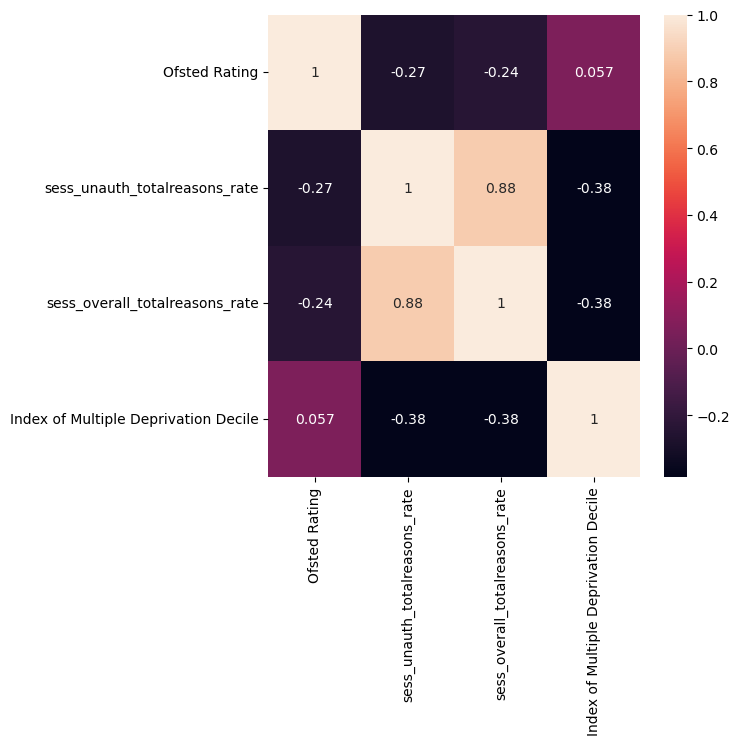

In [384]:
# use a heatmap to explore the pairwise correlations between the variables of interest
plt.figure(figsize=(6,6))    
sns.heatmap(schools_imd[['Ofsted Rating', 'sess_unauth_totalreasons_rate', 
                         'sess_overall_totalreasons_rate', 'Index of Multiple Deprivation Decile']].corr(), 
            annot=True);

The above heatmap suggests that total and unauthorised absence rates have a moderate relationship with IMD, but that Ofsted rating has a trivial relationship with IMD. As expected, the relationship between absence rate and IMD is negative, meaning that as IMD decreases (higher levels of deprivation) absence rates go up. 

There is also a negative relationship between Ofsted rating and absences rates, meaning schools with a better Ofsted rating also tend to have lower absences. 

The same correlation value is observed for both unauthorised and total absence rates with IMD. Looking back to the exploration of the relationship between student level absence data and FSM eligibility, I can see a larger difference between the two cohorts of students for unauthorised absence rates compared to total absence rates, so this will be the absence variable that I continue to explore.  

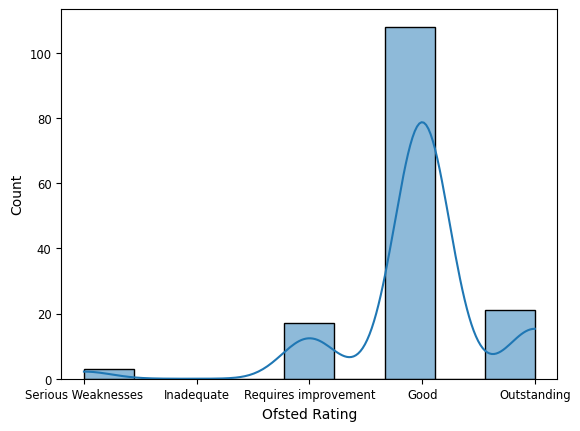

In [385]:
# explore the ditribution of Ofsted ratings
g = sns.histplot(schools['Ofsted Rating'], kde=True)

# set x-axis tick labels
g.set_xticks([x + 1 for x in range(5)],
                  labels=['Serious Weaknesses', 'Inadequate', 'Requires improvement', 'Good', 'Outstanding'])
g.tick_params(labelsize='small');

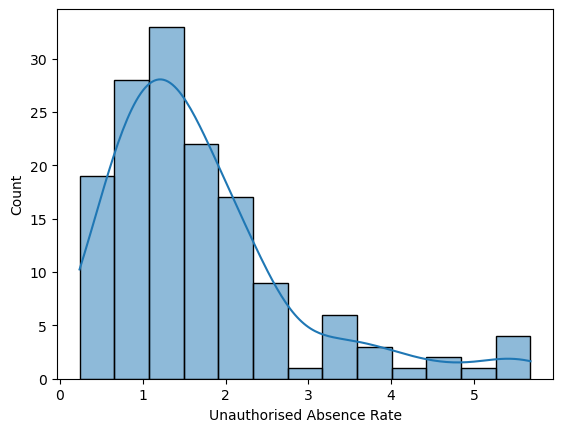

In [386]:
# explore the ditribution of unauthorised absence rates
g = sns.histplot(school_absences['sess_unauth_totalreasons_rate'], kde=True)

plt.xlabel('Unauthorised Absence Rate');

As Ofsted ratings and absence rates are not normally distributed the assumptions of normality for a linear regression are not met. 

I will next read in the shape files so that I can plot the schools within a map of Bradford to visually present the relationship between rates of unauthorised absence by school and the level of deprivation of the Bradford Lower Super Output Areas (LSOAs). 

#### Reading in the shape files
The next steps are to read in the shape files with point coordinates for the school postcodes, and polygon coordinates for Bradford LSOAs. 

The shape file for all school postcodes in Bradford is too large to upload to GitHub, therefore I will first filter to the 25% of schools with the highest absence rate and then retrieve the point coordinates for their individual postcodes from the ONS website to create a shape file small enough to upload. 

In [388]:
# check thresholds for unauthorised absence rate quartiles
school_absences.describe()

,URN,LA (code),EstablishmentNumber,Ofsted Rating,school_urn,sess_unauth_totalreasons_rate,sess_overall_totalreasons_rate
count,146.000000,146.0,146.000000,146.000000,146.000000,146.000000,146.000000
mean,128877.534247,380.0,2930.726027,3.986301,128877.534247,1.695591,4.673438
std,16920.904608,0.0,1222.870882,0.621303,16920.904608,1.133327,1.409622
min,101494.000000,380.0,2000.000000,1.000000,101494.000000,0.236176,2.013596
25%,107305.500000,380.0,2058.750000,4.000000,107305.500000,0.936189,3.764622
50%,139123.500000,380.0,2167.500000,4.000000,139123.500000,1.408776,4.539716
75%,143095.750000,380.0,3378.500000,4.000000,143095.750000,2.057787,5.250972
max,146536.000000,380.0,6909.000000,5.000000,146536.000000,5.681919,9.834033


In [389]:
# filter dataframe to schools with highest 25% of unauthorised absence rate
school_absences_top25 = school_absences.loc[(school_absences['sess_unauth_totalreasons_rate'] >= 2.057787)]
school_absences_top25

,URN,LA (code),EstablishmentNumber,EstablishmentName,TypeOfEstablishment (name),EstablishmentStatus (name),PhaseOfEducation (name),SchoolSponsors (name),OfstedLastInsp,Street,...,TelephoneNum,HeadTitle (name),HeadFirstName,HeadLastName,ParliamentaryConstituency (name),OfstedRating (name),Ofsted Rating,school_urn,sess_unauth_totalreasons_rate,sess_overall_totalreasons_rate
7,146198,380,4073,Dixons Cottingley Academy,Academy sponsor led,Open,Secondary,Dixons Academies Trust,16/11/2022,Cottingley New Road,...,01274-567281,Miss,Francesca,Hitch,Shipley,Good,4,146198,3.985306,8.527382
8,101494,380,3377,Peel Park Primary School and Nursery,Community school,Open,Primary,NaN,11/03/2020,Peel Park Drive,...,01274-639377,Mrs,Andrea,Grist,Bradford East,Good,4,101494,2.238432,5.320368
19,107238,380,2084,Farfield Primary and Nursery School,Community school,Open,Primary,NaN,16/01/2020,Reevy Crescent,...,01274-678545,Mrs,Sarah,Nichols,Bradford South,Good,4,107238,2.319752,4.546444
27,107303,380,3013,St Matthew's CofE Primary School and Nursery,Voluntary controlled school,Open,Primary,NaN,01/02/2018,Ivy House Road,...,01274-731693,Mr,Paul,Urry,Bradford South,Good,4,107303,2.696266,5.764864
28,107305,380,3021,St Luke's CofE Primary School,Voluntary controlled school,Open,Primary,NaN,22/01/2020,Fagley Lane,...,01274-639374,Mrs,Gemma,Zulu,Bradford East,Good,4,107305,2.058122,5.556202
44,135367,380,6906,Bradford Academy,Academy sponsor led,Open,All-through,The Diocese of West Yorkshire and the Dales,12/01/2023,Teasdale Street,...,01274-256789,Mrs,Melanie,Saville,Bradford East,Requires improvement,3,135367,3.814837,7.314532
45,135866,380,6908,Dixons Allerton Academy,Academy sponsor led,Open,All-through,Dixons Academies Trust,06/03/2019,Rhodesway,...,01274-089890,Mr,Danny,Carr,Bradford West,Good,4,135866,2.254426,5.391044
46,136962,380,4613,Feversham Girls' Secondary Academy,Academy converter,Open,Secondary,Feversham Education Trust,10/03/2022,158 Cliffe Road,...,01274-559500,Ms,Sajida,Muneer,Bradford East,Outstanding,5,136962,2.410081,5.135310
48,137320,380,2000,Rainbow Primary Leadership Academy,Free schools,Open,Primary,Star Academies,06/07/2022,Nelson Street,...,01274-221400,Mr,Jonathan,Harris,Bradford East,Good,4,137320,2.497743,4.527007
49,138087,380,4041,Belle Vue Girls' Academy,Academy converter,Open,Secondary,Bradford Diocesan Academies Trust,09/12/2021,Thorn Lane,...,01274-492341,Mrs,Deborah,Anness,Bradford West,Good,4,138087,3.300330,6.445640


In [390]:
# read in the shape file with point coordinates for Bradford postcodes
postcodes = gpd.read_file('ONSPD_Online_Latest_Centroids_top25/ONSPD_Online_Latest_Centroids.shp')

# check the dataframe
postcodes.head()

,OBJECTID,PCD,PCD2,PCDS,DOINTR,DOTERM,OSCTY,CED,OSLAUA,OSWARD,...,LEP2,PFA,IMD,CALNCV,NHSER,ICB,OA21,LSOA21,MSOA21,geometry
0,154520,BD109AQ,BD10 9AQ,BD10 9AQ,198001,None,E99999999,E99999999,E08000032,E05001353,...,None,E23000010,13944,E56000030,E40000012,E54000054,E00177807,E01010685,E02002199,POINT (418108.000 438345.000)
1,154533,BD109BG,BD10 9BG,BD10 9BG,198001,None,E99999999,E99999999,E08000032,E05001353,...,None,E23000010,3292,E56000030,E40000012,E54000054,E00053896,E01010682,E02002201,POINT (418670.000 437257.000)
2,155503,BD128AL,BD12 8AL,BD12 8AL,201209,None,E99999999,E99999999,E08000032,E05001370,...,None,E23000010,1391,E56000030,E40000012,E54000054,E00054801,E01010868,E02002243,POINT (415176.000 427370.000)
3,156395,BD133BH,BD13 3BH,BD13 3BH,198001,None,E99999999,E99999999,E08000032,E05001363,...,None,E23000010,7713,E56000030,E40000012,E54000054,E00177773,E01010794,E02002225,POINT (411847.000 432804.000)
4,158125,BD161TZ,BD16 1TZ,BD16 1TZ,198001,None,E99999999,E99999999,E08000032,E05001343,...,None,E23000010,21671,E56000030,E40000012,E54000054,E00053463,E01010596,E02002204,POINT (411962.000 437252.000)


In [391]:
# merge the schools data into the shape file with postcode coordinates
school_centroids = pd.merge(postcodes, school_absences_top25 [['EstablishmentName', 'Postcode', 'sess_unauth_totalreasons_rate', 'sess_overall_totalreasons_rate']], 
                            left_on='PCDS', right_on='Postcode', how='right')

# check the merged dataframe
school_centroids

,OBJECTID,PCD,PCD2,PCDS,DOINTR,DOTERM,OSCTY,CED,OSLAUA,OSWARD,...,NHSER,ICB,OA21,LSOA21,MSOA21,geometry,EstablishmentName,Postcode,sess_unauth_totalreasons_rate,sess_overall_totalreasons_rate
0,158125,BD161TZ,BD16 1TZ,BD16 1TZ,198001,None,E99999999,E99999999,E08000032,E05001343,...,E40000012,E54000054,E00053463,E01010596,E02002204,POINT (411962.000 437252.000),Dixons Cottingley Academy,BD16 1TZ,3.985306,8.527382
1,162698,BD2 4PR,BD2 4PR,BD2 4PR,200209,None,E99999999,E99999999,E08000032,E05001344,...,E40000012,E54000054,E00054575,E01010831,E02002217,POINT (417549.000 434601.000),Peel Park Primary School and Nursery,BD2 4PR,2.238432,5.320368
2,172789,BD6 2BS,BD6 2BS,BD6 2BS,198001,None,E99999999,E99999999,E08000032,E05001361,...,E40000012,E54000054,E00054667,E01010850,E02002241,POINT (413487.000 429547.000),Farfield Primary and Nursery School,BD6 2BS,2.319752,4.546444
3,172111,BD5 8FG,BD5 8FG,BD5 8FG,201808,None,E99999999,E99999999,E08000032,E05001367,...,E40000012,E54000054,E00054223,E01010747,E02002238,POINT (416368.000 430445.000),St Matthew's CofE Primary School and Nursery,BD5 8FG,2.696266,5.764864
4,162453,BD2 3NS,BD2 3NS,BD2 3NS,198001,None,E99999999,E99999999,E08000032,E05001350,...,E40000012,E54000054,E00054598,E01010825,E02002214,POINT (418661.000 435412.000),St Luke's CofE Primary School,BD2 3NS,2.058122,5.556202
5,170822,BD4 7QJ,BD4 7QJ,BD4 7QJ,198001,None,E99999999,E99999999,E08000032,E05001345,...,E40000012,E54000054,E00053576,E01010615,E02002235,POINT (417925.000 431215.000),Bradford Academy,BD4 7QJ,3.814837,7.314532
6,174319,BD8 0DH,BD8 0DH,BD8 0DH,198001,None,E99999999,E99999999,E08000032,E05001348,...,E40000012,E54000054,E00176098,E01010629,E02002222,POINT (412691.000 433642.000),Dixons Allerton Academy,BD8 0DH,2.254426,5.391044
7,169359,BD3 0LT,BD3 0LT,BD3 0LT,198001,None,E99999999,E99999999,E08000032,E05001344,...,E40000012,E54000054,E00054583,E01010830,E02002217,POINT (416820.000 434393.000),Feversham Girls' Secondary Academy,BD3 0LT,2.410081,5.135310
8,171479,BD5 0HD,BD5 0HD,BD5 0HD,199007,None,E99999999,E99999999,E08000032,E05001358,...,E40000012,E54000054,E00054156,E01010730,E02002227,POINT (416544.000 432260.000),Rainbow Primary Leadership Academy,BD5 0HD,2.497743,4.527007
9,175810,BD9 6NA,BD9 6NA,BD9 6NA,198001,None,E99999999,E99999999,E08000032,E05001352,...,E40000012,E54000054,E00053869,E01010669,E02002212,POINT (412423.000 435936.000),Belle Vue Girls' Academy,BD9 6NA,3.300330,6.445640


In [392]:
# check for missing values
school_centroids['geometry'].isnull().sum()

0

For the above merge, I tried matching 'PCD', 'PCD2' and 'PCDS' from the shape file to 'Postcode' in the schools dataframe. Only 'PCDS' resulted in 100% match.  

The next step is to read in the polygon shape file for the Bradford LSOAs. 

In [393]:
# read in shape file 
lsoa = gpd.read_file('Lower_layer_Super_Output_Areas_2021_EW_BFC_V8/LSOA_2021_EW_BFC_V8.shp')

# check dataframe
lsoa.head()

,LSOA21CD,LSOA21NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,E01010947,Calderdale 023B,415303,421781,-1.76973,53.6923,27896a78-71ce-4f51-b7e2-83e529038465,"POLYGON ((414708.000 422491.000, 414736.000 42..."
1,E01011923,Wakefield 019B,432713,421695,-1.50610,53.6907,b476b75c-2e3c-43e0-93ee-b50c9a9bec4e,"POLYGON ((433084.718 422046.958, 433080.076 42..."
2,E01010607,Bradford 064C,417646,433632,-1.73358,53.7987,ec228a44-498a-4137-8fc2-4be9c327d538,"POLYGON ((417710.130 433891.824, 417711.813 43..."
3,E01011292,Leeds 071B,426984,433378,-1.59183,53.7960,7f0c3c65-38f6-4713-9d72-ce8013615f00,"POLYGON ((426955.999 433621.000, 426957.357 43..."
4,E01011649,Leeds 022B,434474,439541,-1.47744,53.8510,dab83c56-ab7a-4dce-9147-ceb58ff8110d,"POLYGON ((434985.786 440419.754, 435000.056 44..."


In [394]:
# read in data showing IMD by LSOA
imd = pd.read_csv('IMD2019_Index_of_Multiple_Deprivation.csv')

# check dataframe
imd.head()

,LSOA code (2011),LSOA name (2011),Local Authority District code (2019),Local Authority District name (2019),Index of Multiple Deprivation (IMD) Rank,Index of Multiple Deprivation (IMD) Decile
0,E01000001,City of London 001A,E09000001,City of London,"29,199",9
1,E01000002,City of London 001B,E09000001,City of London,"30,379",10
2,E01000003,City of London 001C,E09000001,City of London,"14,915",5
3,E01000005,City of London 001E,E09000001,City of London,"8,678",3
4,E01000006,Barking and Dagenham 016A,E09000002,Barking and Dagenham,"14,486",5


In [395]:
# filter dataframe to only Bradford LSOAs 
imd_bradford = imd.loc[imd['Local Authority District name (2019)'] == 'Bradford']

# check filtering has worked as expected
imd_bradford.head()

,LSOA code (2011),LSOA name (2011),Local Authority District code (2019),Local Authority District name (2019),Index of Multiple Deprivation (IMD) Rank,Index of Multiple Deprivation (IMD) Decile
10261,E01010568,Bradford 016A,E08000032,Bradford,"23,447",8
10262,E01010569,Bradford 016B,E08000032,Bradford,"5,775",2
10263,E01010570,Bradford 018A,E08000032,Bradford,"29,423",9
10264,E01010571,Bradford 016C,E08000032,Bradford,"6,829",3
10265,E01010572,Bradford 016D,E08000032,Bradford,"22,844",7


In [396]:
# combine spatial and IMD data for Bradford LSOAs
imd_bradford_lsoa = pd.merge(lsoa, imd_bradford [['LSOA code (2011)', 
                                                  'Index of Multiple Deprivation (IMD) Decile']],  
                                left_on='LSOA21CD', 
                                right_on='LSOA code (2011)', 
                                how='right')
# check dataframe
imd_bradford_lsoa.head()

,LSOA21CD,LSOA21NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,LSOA code (2011),Index of Multiple Deprivation (IMD) Decile
0,E01010568,Bradford 016A,416258.0,438952.0,-1.75437,53.8466,0281d0eb-2a6f-4410-9946-d87c7f54b96a,"POLYGON ((416422.170 439366.289, 416417.848 43...",E01010568,8
1,E01010569,Bradford 016B,414693.0,438453.0,-1.77818,53.8421,9d629a54-8d36-482d-b223-411decdffa9b,"POLYGON ((415369.043 439212.461, 415368.435 43...",E01010569,2
2,E01010570,Bradford 018A,413992.0,438990.0,-1.78881,53.8470,388d8821-72f3-4dc5-a9ff-63c1df687ea2,"POLYGON ((414005.260 439378.989, 414146.534 43...",E01010570,9
3,E01010571,Bradford 016C,415223.0,438398.0,-1.77013,53.8416,de49148f-b8bb-4828-9465-5ff47b599e88,"POLYGON ((415768.621 438654.729, 415766.728 43...",E01010571,3
4,E01010572,Bradford 016D,415428.0,438857.0,-1.76699,53.8457,3d4b7a55-423a-408e-ab2e-9295a461fc15,"POLYGON ((415616.807 439194.596, 415622.818 43...",E01010572,7


In [397]:
# check whether the two files use same crs
print(imd_bradford_lsoa.crs, school_centroids.crs)

EPSG:27700 EPSG:27700


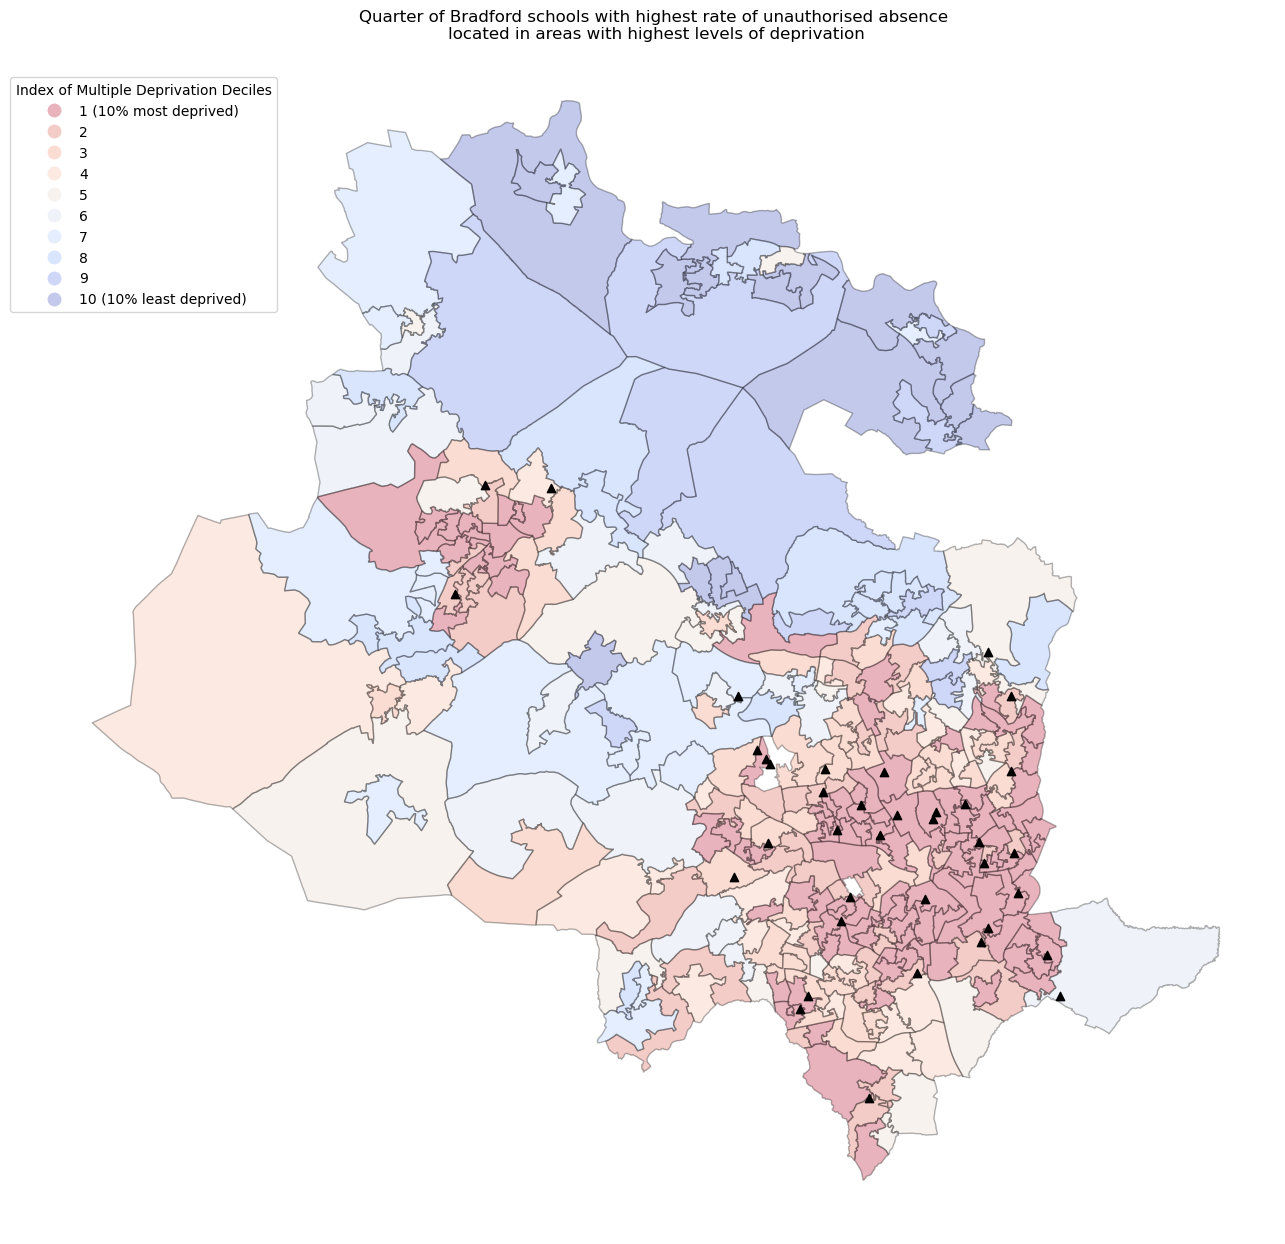

In [398]:
# create a plot
f, ax = plt.subplots(1, figsize=(16, 16))

# define the basemap plot
base = imd_bradford_lsoa.plot(ax=ax, column='Index of Multiple Deprivation (IMD) Decile', 
                              scheme='userdefined', classification_kwds={'bins':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}, 
                              cmap='coolwarm_r', alpha=0.3, edgecolor='k', legend=True)

# plot the schools on the basemap axis
schools = school_centroids.plot(ax=base, color='black', marker='^', edgecolor='k')


# add map title
ax.set_title('Quarter of Bradford schools with highest rate of unauthorised absence \nlocated in areas with highest levels of deprivation')

# set legend1 title
leg1 = ax.get_legend()
leg1.set_title("Index of Multiple Deprivation Deciles")

# change legend1 labels
for i in range(1, 11):
    leg1.get_texts()[i-1].set_text(i)
leg1.get_texts()[0].set_text('1 (10% most deprived)') 
leg1.get_texts()[9].set_text('10 (10% least deprived)') 

# position legend
leg1.set_bbox_to_anchor((.2, .98))


# remove axis
ax.set_axis_off()


plt.show();

## Visualisation 2

Visualisation 2 shows that schools in Bradford are primarily clustered to the South East, in and around Bradford City, with another smaller cluster around the town of Keighley. Schools with the highest unauthorised absence rates tend to be located in LSOAs with high levels of deprivation. 

With Bradford City Council as the intended audience, this visualisation is more accessible than the pairwise correlation table as a way of communicating the relationship between school absence rates and the level of deprivation in the school area. The impact of this visualisation would be a greater awareness of poverty as a potential underlying risk factor for higher absence rates in schools located in areas with higher deprivation. This could influence the School Standards team (within the council's Education Service) to approach schools with poor attendance rates in a more supportive way, rather than simply viewing high absences as poor school performance. 

LSOAs provide an appropriate level of granularity for visualising the levels of deprivation in the areas schools are in, and choropleth mapping is an ideal way of depicting the variation in deprivation deciles across a geographic area. I chose the 'coolwarm_r' colour map so that the darker reds (commonly associated with risk) would represent the highest levels of deprivation. I chose 10 'bins' for the choropleth scale to reflect the IMD deciles. 

I have made quite a few amendments to the basemap legend to make the visualisation easier to interpret, inlcuding relabelling the scale with the IMD deciles 1 to 10 and adding text annotations to the top and bottom of the scale so that the direction of the scale is explicit, i.e. that '1' represents the most deprived and '10' the least. I have also adjusted the position of the legend to make it more accessible and to avoid any overlap with the map. 

I have chosen black markers for the schools so that they standout against the coloured background. The triangle marker shape helps to avoid confusing them with the round markers on the base map legend. 

## Summary and Social Impact

School attendance is often seen and used as a performance metric, both for children and for schools. Frequent school absense may be treated as a behaviour issue for the student, and overall attendance rates form part of the statutory returns submitted by schools to the Department for Education, and inform judgements made by Ofsted. 

Instead, in recognition of the role that poverty plays in increasing the risk of school absence for both students and schools, it may be more constructive to view poor attendance rates as a symptom of underlying disadvantage and therefore a trigger to offer more targeted support. 

Markdown word count: 1521